# Traffic Sign Recognition Classifier

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
tf.version.VERSION

'2.7.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
assert(physical_devices)

In [5]:
print(physical_devices)
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# imports
import numpy as np
import pickle
import os

In [7]:
output_dir = "./output" # directory for generated graphics and images

In [8]:
seed = 0
tf.keras.utils.set_random_seed(
    seed
)


---
## Loading traffic sign data 

In [9]:
# Load pickled data

data_dir = "./traffic-signs-data"
training_file = os.sep.join([data_dir, "train.p"])
validation_file= os.sep.join([data_dir, "valid.p"])
testing_file = os.sep.join([data_dir, "test.p"])

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [10]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from traffic_sign_classifier.utils import group_by_category, load_signnames
# Loading the classes/categories names
class2label = load_signnames(os.sep.join([data_dir, "signnames.csv"]))

# by_category_sample = group_by_category(y_train)

In [13]:
os.path.join(output_dir, "images_preview.jpg")

'./output/images_preview.jpg'

#### Traffic sign images preview for all the classes

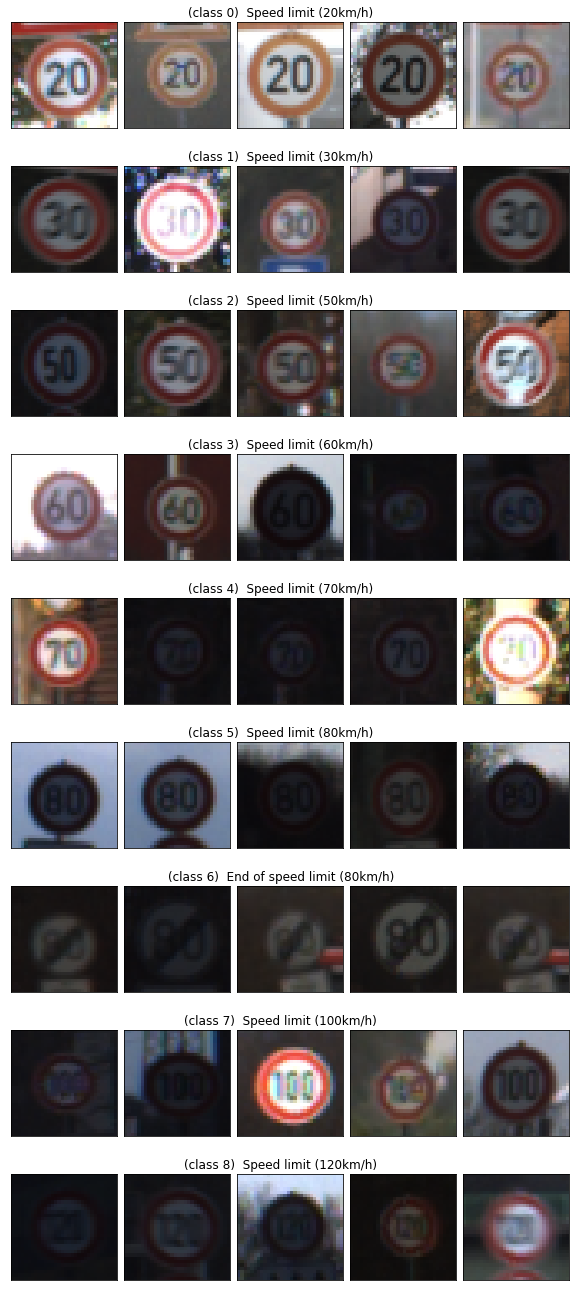

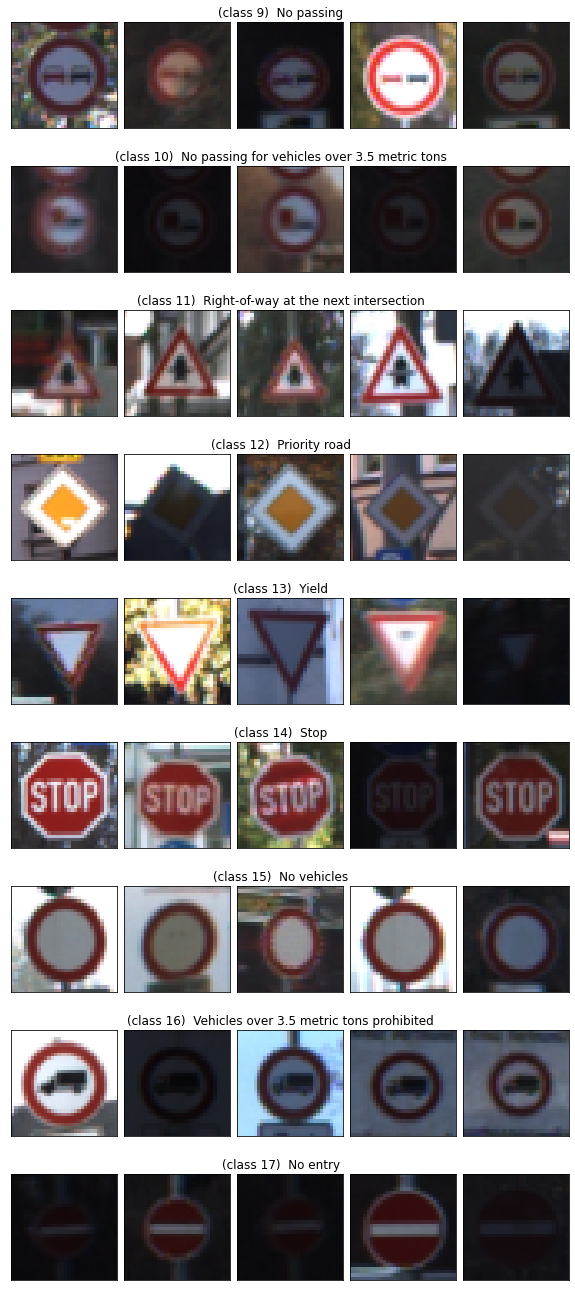

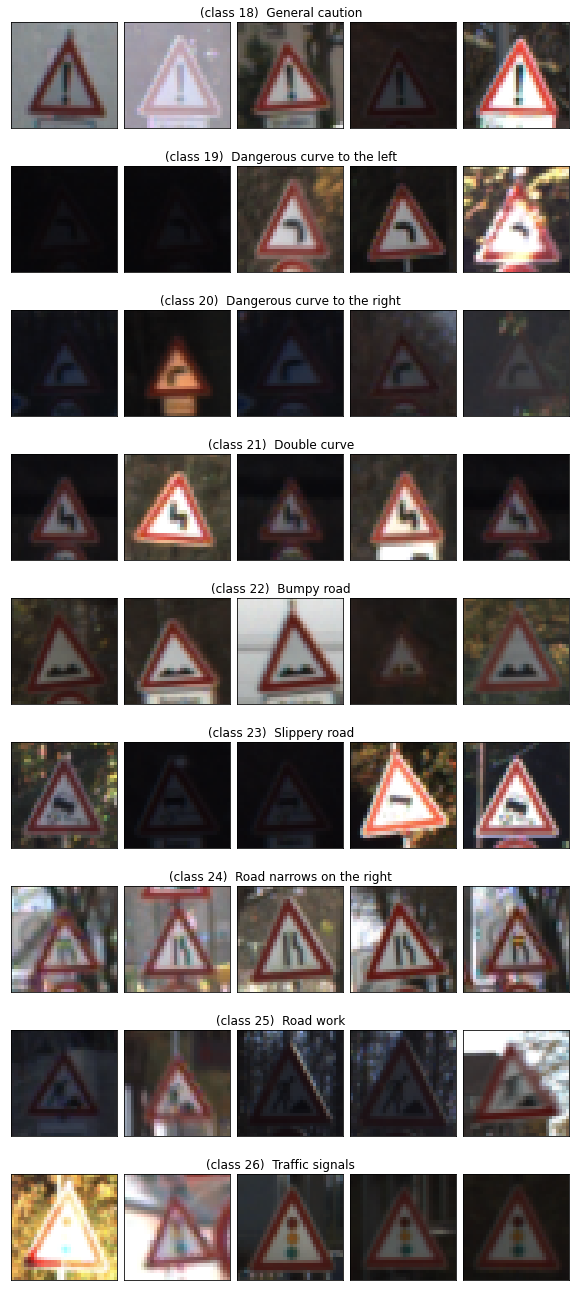

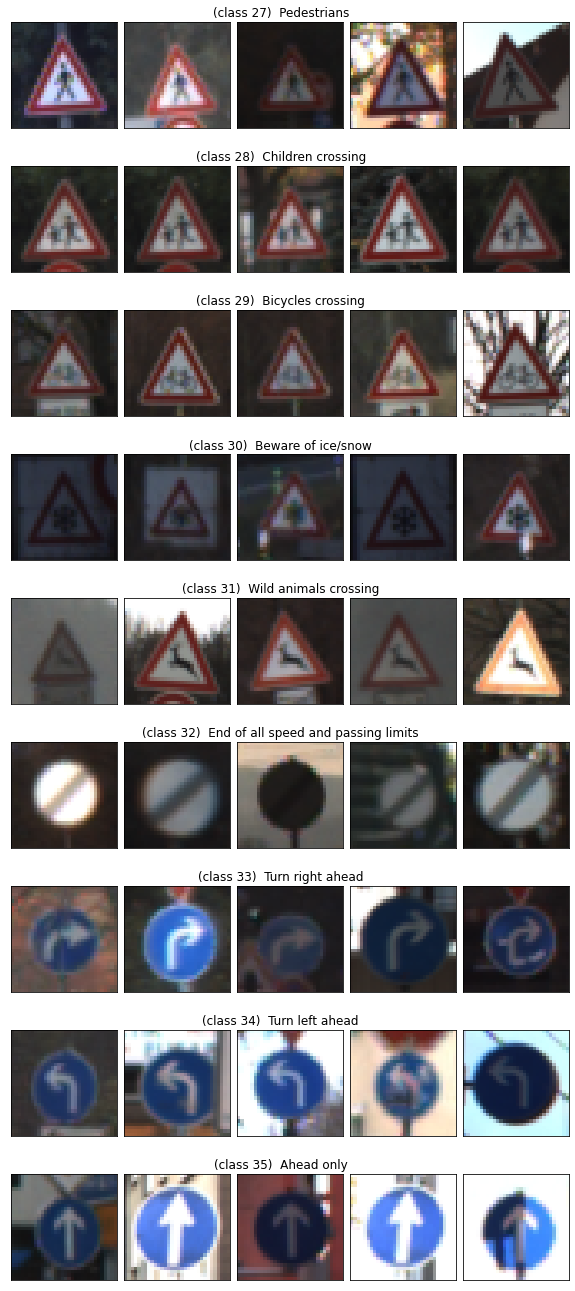

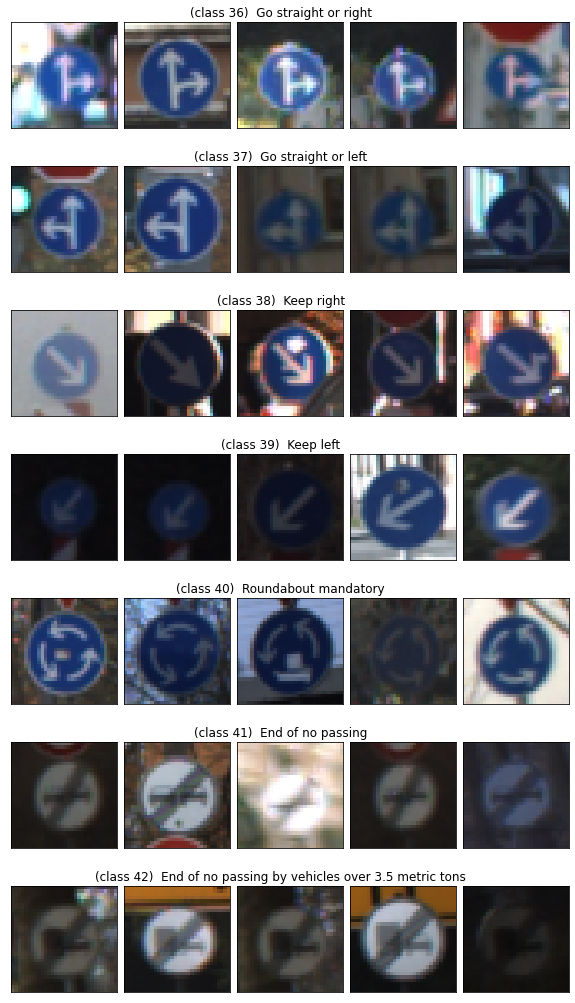

In [14]:
from traffic_sign_classifier.visualization import grid_visu

grid_visu(X_train, labels=y_train, sample_size=5, categories_per_fig=9, # , categories=range(10),
          label_to_name=class2label,
          shuffle=True, output_dir_path="./output/previews")

#### Categories/classes distribution (in train/validation/test)

In [15]:
# Grouping dataset by categories using the labels
category_grouped_datasets = {} # A dictionary per datatset grouping the sample with their attributes
for dataset, data_ in [ ("train", y_train), ("test", y_test), ("validation", y_valid)]:
    print(f"{dataset} data set size -> {len(data_)}")
    category_grouped_datasets[dataset] = group_by_category(data_) 

train data set size -> 34799
test data set size -> 12630
validation data set size -> 4410


In [16]:
# Categories/classese distribution (in train/validation/test)
from collections import defaultdict
from typing import Optional

def  visualize_datasets_distribution(category_grouped_datasset_dict, output_dir:str =output_dir, output_file_name:Optional[str]=None):
    """ A helper to visualize datasets distribution """
    plt.figure(figsize=(10, 16))
    bar_width = 0.3
    width_offset = 0
    for dataset, by_category in  category_grouped_datasset_dict.items():
        # Plotting 
        categories, sizes = zip(*[(category, len(items)) for category, items in sorted(by_category.items(), key=lambda x: len(x[1]), reverse=False)])
        plt.barh([width_offset + item for item in range(len(categories))], sizes, height=bar_width,
                 tick_label=[class2label.get(item, item) for item in categories],
                 label=f"{dataset} dataset")
        width_offset += bar_width
    plt.legend()
    plt.title(f"Train/validation/test classes distribution")
    plt.grid()
    # Saving the figure to a file (file should ends png)
    if isinstance(output_file_name, str) and output_file_name.endswith(".png"):
        plt.savefig(os.path.join(output_dir,output_file_name))

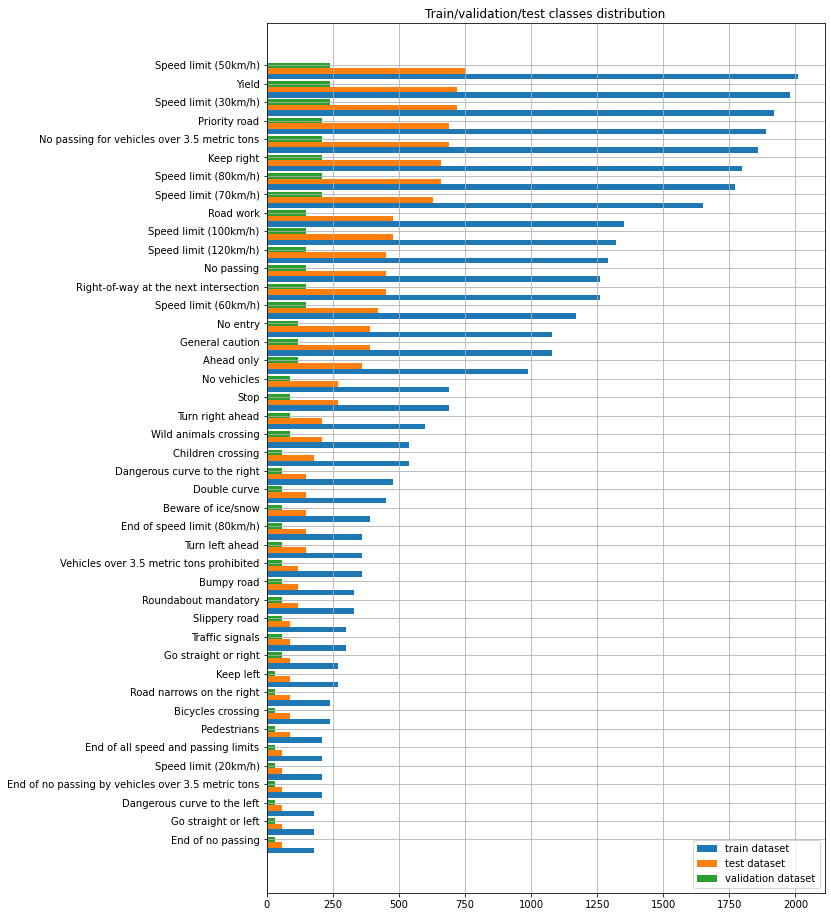

In [17]:
visualize_datasets_distribution(category_grouped_datasets, output_file_name="classes_distribution.png")

## Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. An apporximation is done by centralizing and scaling impemented as a preprocessing layers of the neural network (see `preprocessing_layers` intialization in  Model architecture section).


Here we will augment the data generating sample from random transformation applyied on the classes with few training examples/samples. 


Optionally during the training data augmentation layers are used to alter the data making the model a bit more robust to some transformation change/range. (see training model section)

In [18]:


from functools import reduce
from sklearn.utils import resample

In [19]:
# Selecting categories with few example to augment
# Let's select all the category below 1000 example in the training and 
# generate the complementart to `category_size_threshold` to add 

category_size_threshold = 500

to_augment = {category: resample(items, n_samples=category_size_threshold-len(items), replace=True, stratify=items) for category, items in 
              sorted(category_grouped_datasets["train"].items(), key=lambda x: len(x[1])) if len(items)< category_size_threshold}


In [20]:
to_augment_items = reduce(lambda x, y: x+y, to_augment.values()) 

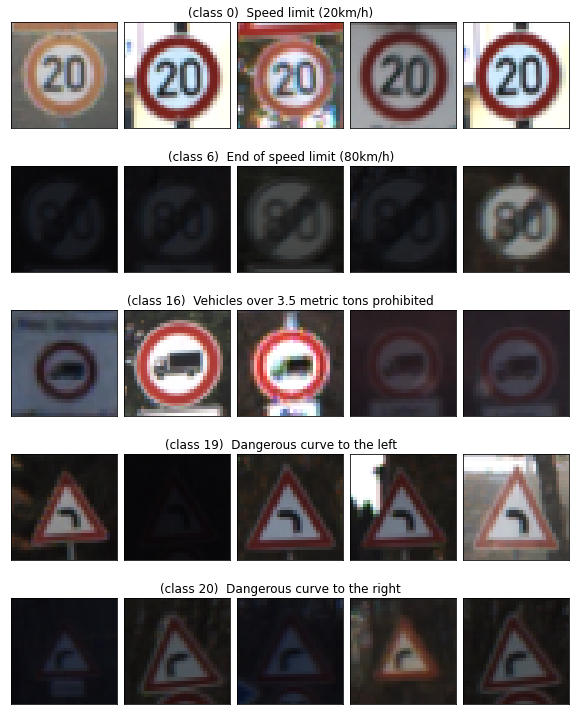

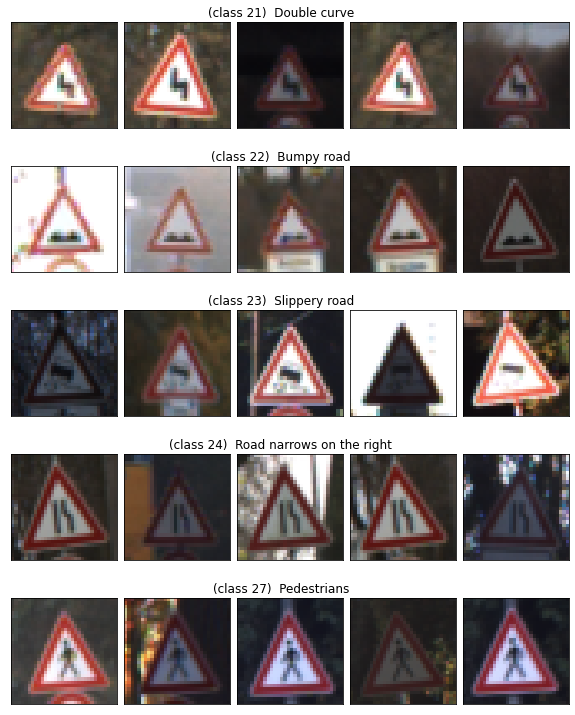

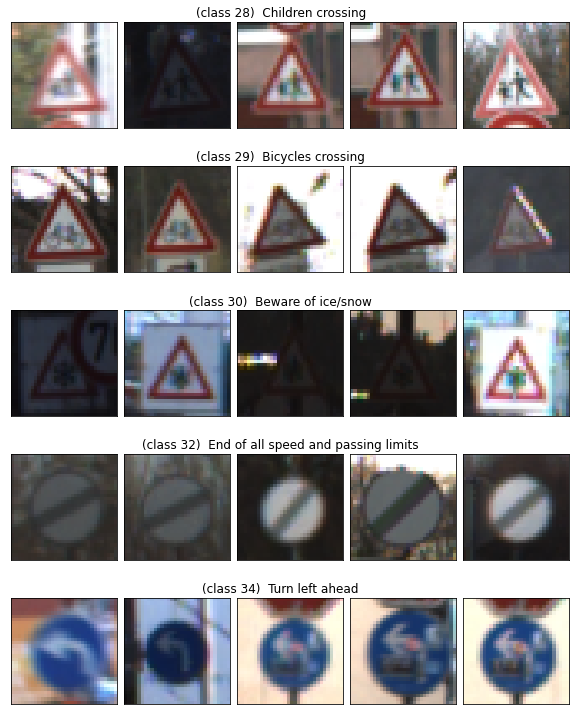

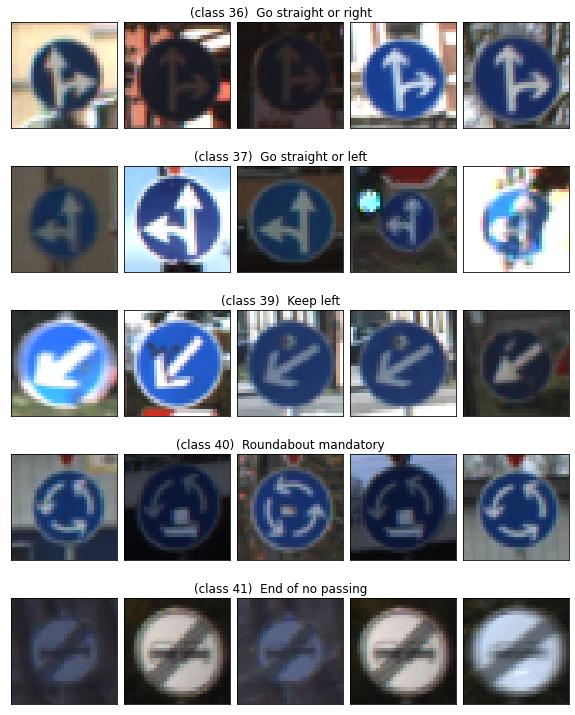

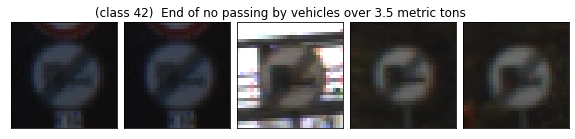

In [21]:
# Visualize items to augment

grid_visu(X_train[to_augment_items], labels=y_train[to_augment_items], sample_size=5, categories_per_fig=5,
          label_to_name=class2label,
          shuffle=True, output_dir_path="./output/to_augment")

### Generating and balancing data

In [22]:
# Generate augmented (transformed data) dataset from the resampled data ( categories with few examples < category_size_threshold)
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, CenterCrop
from tensorflow.keras.layers import RandomTranslation, RandomContrast, RandomZoom, RandomContrast
from tensorflow.keras import Sequential


# Define augmentation layers 
augmentation_layers = [
    RandomRotation(.02), 
    # GaussianNoise(4, 0, dtype='uint8')
    RandomTranslation(.1, .1),
    RandomZoom(height_factor=(-0.1, -0.0)),
    RandomContrast(.1)
    ]

augmentation = Sequential(augmentation_layers)

generated = (tf.data.Dataset.from_tensor_slices((X_train[to_augment_items], y_train[to_augment_items])).
             batch(256).map(lambda x, y: (augmentation(x, training=True), y),  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
            )


In [23]:
from collections import Counter
categories_counter = Counter()

# Collecting the generated data

gen_X = []
gen_y = []
for batch_X, batch_y in  generated:
    gen_X.append(np.array(batch_X))
    gen_y.append(np.array(batch_y))
    categories_counter.update(np.array(batch_y))


gen_X = np.concatenate(gen_X)
gen_y = np.concatenate(gen_y)


# Append it to the original data as (augmented)

print(f" augmentation -> {categories_counter}")

augmented_X = np.concatenate((X_train, gen_X))
augmented_y = np.concatenate((y_train, gen_y))

augmented_sample_per_category = Counter(augmented_y)
print(f" augmented -> {augmented_sample_per_category}")


# A Sanity check (after merge all the category should at least have `category_size_threshold` samples)
assert(all([cnt >= category_size_threshold for _, cnt in augmented_sample_per_category.items()]))     

 augmentation -> Counter({37: 320, 19: 320, 0: 320, 41: 290, 42: 290, 32: 290, 27: 290, 29: 260, 24: 260, 39: 230, 21: 230, 40: 200, 20: 200, 36: 170, 22: 170, 16: 140, 34: 140, 6: 140, 30: 110, 23: 50, 28: 20})
 augmented -> Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 35: 1080, 18: 1080, 17: 990, 31: 690, 14: 690, 33: 599, 26: 540, 15: 540, 41: 500, 36: 500, 23: 500, 40: 500, 22: 500, 37: 500, 16: 500, 19: 500, 42: 500, 0: 500, 32: 500, 27: 500, 29: 500, 24: 500, 34: 500, 6: 500, 30: 500, 39: 500, 21: 500, 20: 500, 28: 500})


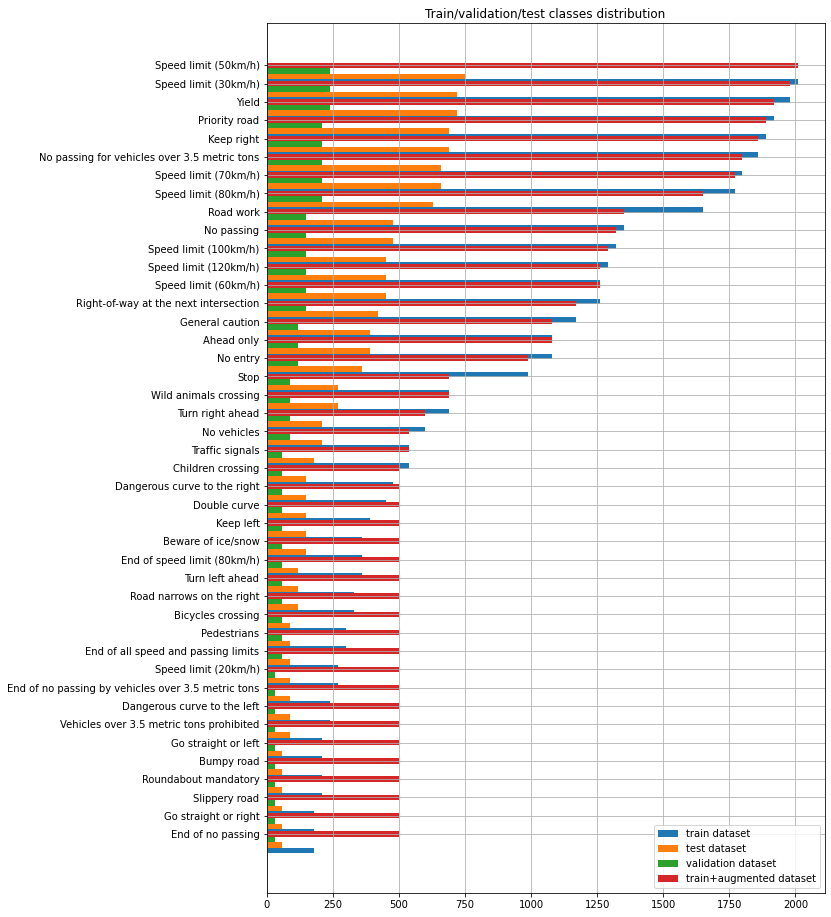

In [24]:
category_grouped_datasets["train+augmented"] = group_by_category(augmented_y)
visualize_datasets_distribution(category_grouped_datasets, output_file_name="classes_distribution_with_augmented.png")

### Visualize generated samples per category

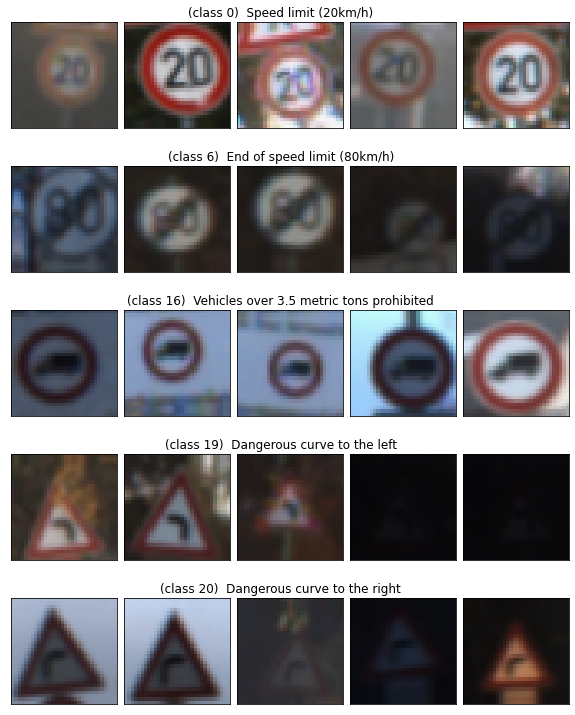

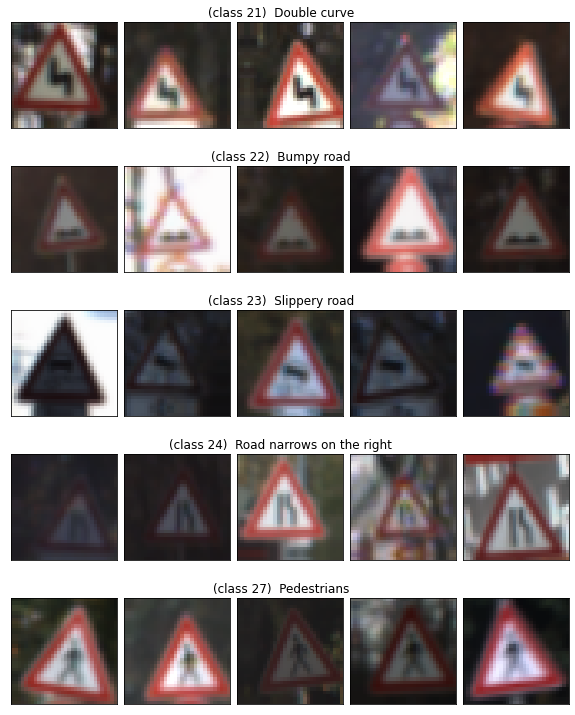

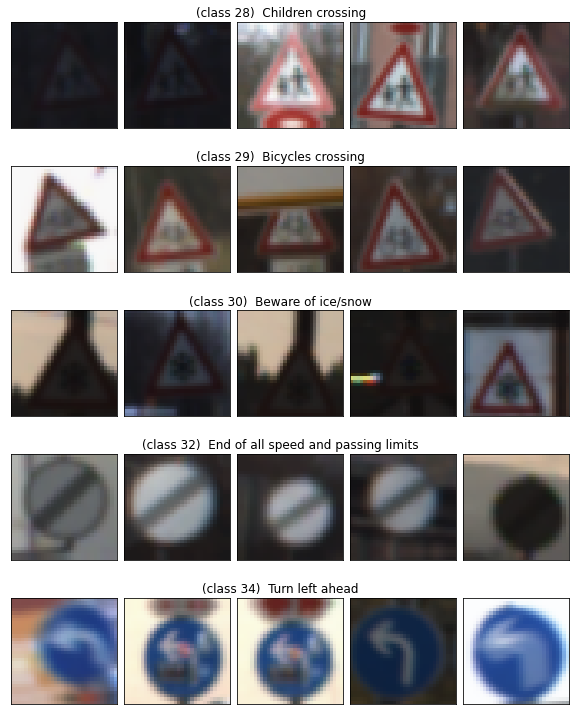

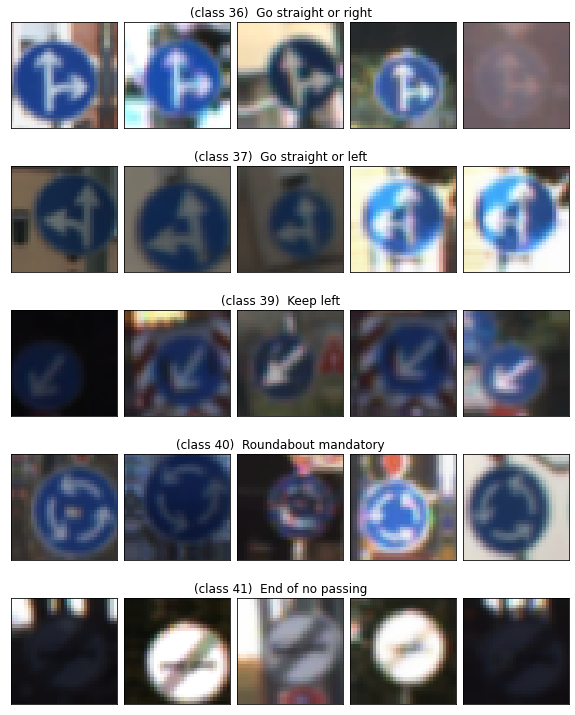

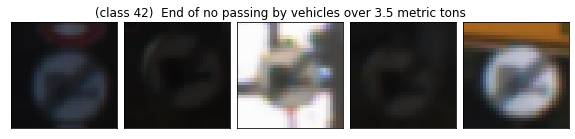

In [25]:
grid_visu(np.array(gen_X), labels=list(gen_y), sample_size=5, categories_per_fig=5,
      label_to_name=class2label,
      shuffle=True, output_dir_path="./output/augmentation_generation")


## Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


Model requirements:

To meet specifications, the validation set accuracy will need to be at least 0.93.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

An example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

In [26]:
# from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise

### Model Architecture

Le Net is chosen to be the baseline architecture. Augmentation and slightly variated architecture are evaluated for performance gain.

In [27]:
from traffic_sign_classifier.nn.lenet import LeNet, ConvLayerConfig
from datetime import datetime


In [28]:
preprocessing_layers = [
  Resizing(32, 32),
  Rescaling(scale=1./127.5, offset=-1)
]

In [29]:
# Setting up networks (and models) to compare
# TODO: add a Gray-Level model
# TODO: use model name to name layers


logits = False # append a Softmax activation ! set to true to keep the logits output

networks = {
        "tsc_baseline": LeNet(categ_nbr=n_classes, logits=logits,
                              preprocessing_layers = preprocessing_layers,
                              name="tsc_baseline",
                              batch_norm=False,
                              dropout=0)
                            ,
        "tsc_lenet_batch-norm_dropout": LeNet(categ_nbr=n_classes, logits=logits,
                               preprocessing_layers = preprocessing_layers,
                               name="tsc_lenet_batch-norm_dropout"),
        "tsc_lenet_always_augment": LeNet(categ_nbr=n_classes, logits=logits,
                                                 preprocessing_layers = preprocessing_layers,
                                                 augmentation_layers= augmentation_layers,
                                        name="tsc_lenet_always_augment"),

            "tsc_lenet_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(5, 5)),
                            2: ConvLayerConfig(filters=32, kernel_size=(5, 5)),
                            },
                       name="tsc_lenet_more_filters",
                     ),
                "tsc_lenet_7x7_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(7, 7)),
                            2: ConvLayerConfig(filters=32, kernel_size=(7, 7)),
                            },
                       name="tsc_lenet_7x7_more_filters",
                     ),
                    "tsc_lenet_11x11_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(11, 11)),
                            2: ConvLayerConfig(filters=32, kernel_size=(7, 7)),
                            },
                       name="tsc_lenet_11x11_more_filters",
                     )
            
           }

In [30]:
# Include network name in layer naming
# TODO summary to md 

def md_summary(model):
    for layer in model.layers:
        print(f"{layer.name}{layer.__class__}")

md_summary(networks.get("tsc_lenet_more_filters"))
        

conv2d_6<class 'keras.layers.convolutional.Conv2D'>
batch_normalization_4<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
max_pooling2d_6<class 'keras.layers.pooling.MaxPooling2D'>
conv2d_7<class 'keras.layers.convolutional.Conv2D'>
batch_normalization_5<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
max_pooling2d_7<class 'keras.layers.pooling.MaxPooling2D'>
flatten_3<class 'keras.layers.core.flatten.Flatten'>
dropout_2<class 'keras.layers.core.dropout.Dropout'>
dense_9<class 'keras.layers.core.dense.Dense'>
dense_10<class 'keras.layers.core.dense.Dense'>
dense_11<class 'keras.layers.core.dense.Dense'>


In [31]:
# init models
for name , network in  networks.items():
    # setup model with arbitrary image size as input (arch. already setup to resize)
    print(f"building (models) for {name}")
    network.build_models(input_=tf.keras.Input(shape=(None, None, 3)))
    network.model.summary()
    
    # network.pred_model.summary()


building (models) for tsc_baseline
Model: "tsc_baseline.training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
          

Model: "tsc_lenet_11x11_more_filters.training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 12)        4368      
                                                                 
 batch_normalization_8 (Batc  (None, 22, 22, 12)       48        
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 12)       0         
 g2D)                        

# Add loss and compile model

In [32]:
optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for _, network in  networks.items():
    network.compile_model(optimizer=optimizer, metrics=["accuracy"])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validationsets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [33]:
assert(set(augmented_y)==set(y_valid)) # a sanity check that all the labels appear in both train and validation

y_train_categorical = to_categorical(augmented_y)
y_valid_categorical = to_categorical(y_valid)

In [34]:
# Sanity check
assert y_train_categorical.shape[1] == y_valid_categorical.shape[1]

In [35]:
y_train_categorical.shape

(39239, 43)

In [36]:
# Shuffling (also could be done within the training it self, but better externally for better model comparability)

### Setting-up callbacks

In [37]:

# Tensor board setup
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [38]:
# Set early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [39]:
from collections import defaultdict

history = defaultdict(lambda: [])  # to support interactive training: multi-round of multiple epochs.

### Training

In [40]:
EPOCHS = 50
BATCH_SIZE = 256 # to variate the batch_size

# Train all the test networks (sequentially)

for name, network in networks.items():
    print(f"training -> {name}")
    history[name].append(network.model.fit(augmented_X,  y_train_categorical,
        validation_data=(X_valid,  y_valid_categorical), shuffle=True, # TODO: shuffle externally and set shuffle to False
        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback, early_stopping_callback]))

training -> tsc_baseline
Epoch 1/50
154/154 [==============================] - 4s 15ms/step - loss: 1.6872 - accuracy: 0.5405 - val_loss: 0.9252 - val_accuracy: 0.7401
Epoch 2/50
154/154 [==============================] - 2s 14ms/step - loss: 0.4343 - accuracy: 0.8809 - val_loss: 0.6735 - val_accuracy: 0.8349
Epoch 3/50
154/154 [==============================] - 2s 13ms/step - loss: 0.2414 - accuracy: 0.9341 - val_loss: 0.5192 - val_accuracy: 0.8694
Epoch 4/50
154/154 [==============================] - 2s 13ms/step - loss: 0.1630 - accuracy: 0.9549 - val_loss: 0.4707 - val_accuracy: 0.8966
Epoch 5/50
154/154 [==============================] - 2s 13ms/step - loss: 0.1159 - accuracy: 0.9679 - val_loss: 0.5333 - val_accuracy: 0.8971
Epoch 6/50
154/154 [==============================] - 2s 13ms/step - loss: 0.0886 - accuracy: 0.9756 - val_loss: 0.5254 - val_accuracy: 0.9025
Epoch 7/50
154/154 [==============================] - 2s 13ms/step - loss: 0.0686 - accuracy: 0.9812 - val_loss: 0.60

154/154 [==============================] - 2s 15ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.2852 - val_accuracy: 0.9401
Epoch 20/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0202 - accuracy: 0.9930 - val_loss: 0.2765 - val_accuracy: 0.9474
Epoch 21/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.4997 - val_accuracy: 0.9170
Epoch 22/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.2880 - val_accuracy: 0.9458
Epoch 23/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.4566 - val_accuracy: 0.9333
Epoch 24/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.3446 - val_accuracy: 0.9385
Epoch 25/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0265 - accuracy: 0.9918 - val_loss: 0.3145 - val_accuracy: 0.9431
Epoc

154/154 [==============================] - 2s 15ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.3653 - val_accuracy: 0.9304
Epoch 25/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.3541 - val_accuracy: 0.9293
Epoch 26/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.3649 - val_accuracy: 0.9390
Epoch 27/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.3479 - val_accuracy: 0.9381
Epoch 28/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.3029 - val_accuracy: 0.9420
Epoch 29/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.3379 - val_accuracy: 0.9392
Epoch 30/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.3304 - val_accuracy: 0.9413
Epoc

154/154 [==============================] - 2s 15ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.5008 - val_accuracy: 0.9354
Epoch 32/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0168 - accuracy: 0.9949 - val_loss: 0.3748 - val_accuracy: 0.9476
Epoch 33/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.2097 - val_accuracy: 0.9685
Epoch 34/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.3476 - val_accuracy: 0.9379
Epoch 35/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0138 - accuracy: 0.9957 - val_loss: 0.2978 - val_accuracy: 0.9587
Epoch 36/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.2663 - val_accuracy: 0.9558
Epoch 37/50
154/154 [==============================] - 2s 15ms/step - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.3063 - val_accuracy: 0.9519
Epoc

In [41]:
history.keys()

dict_keys(['tsc_baseline', 'tsc_lenet_batch-norm_dropout', 'tsc_lenet_always_augment', 'tsc_lenet_more_filters', 'tsc_lenet_7x7_more_filters', 'tsc_lenet_11x11_more_filters'])

### Training summary visualization

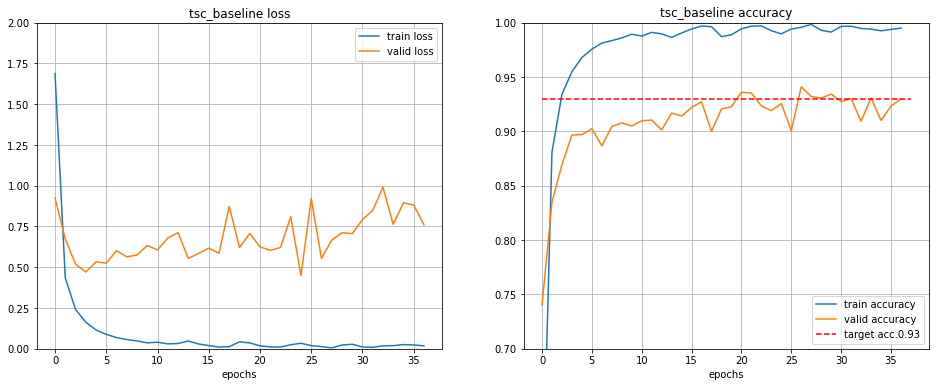

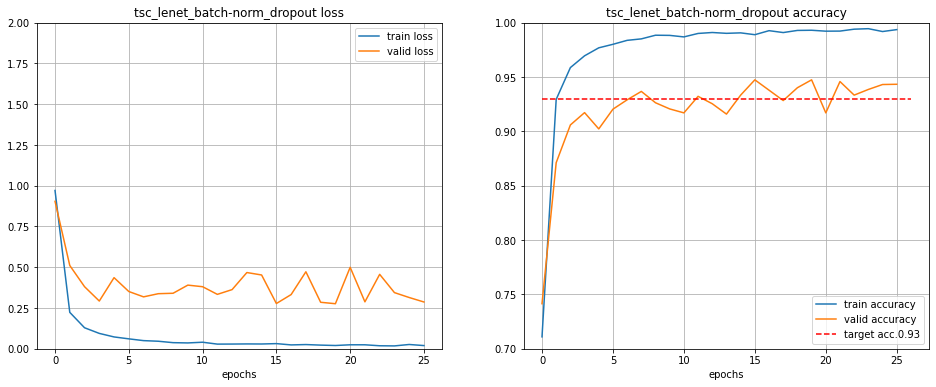

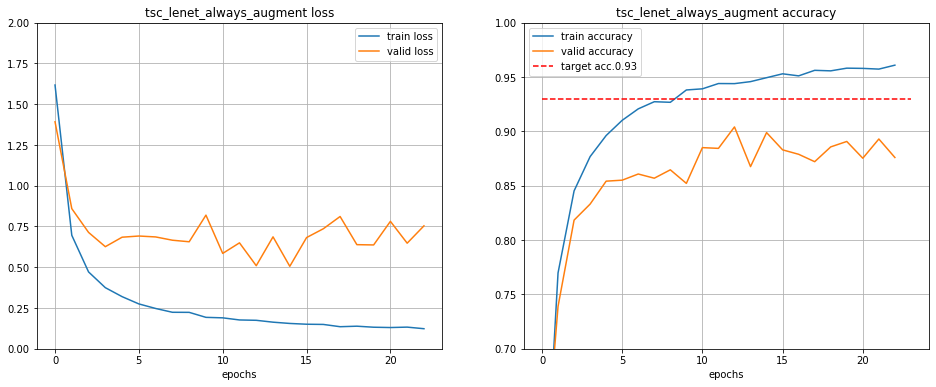

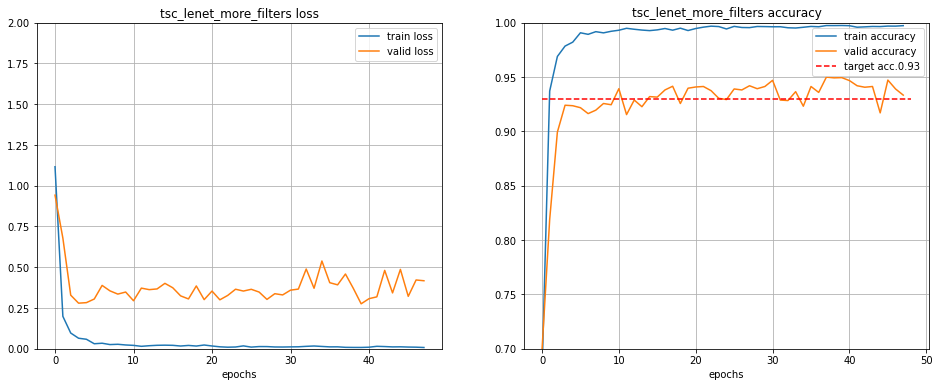

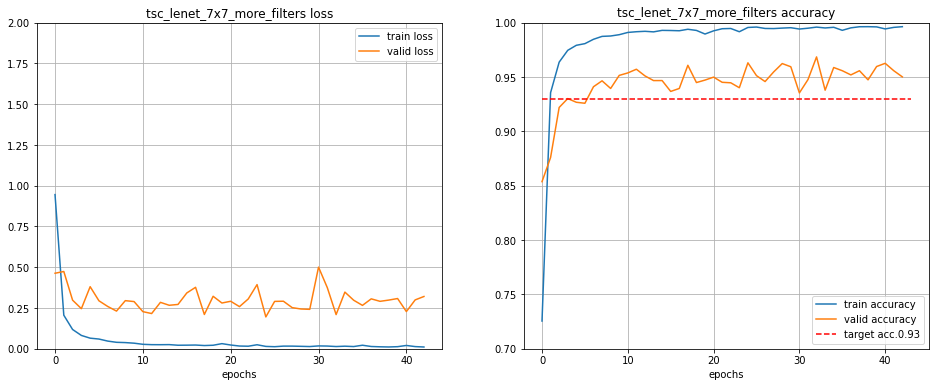

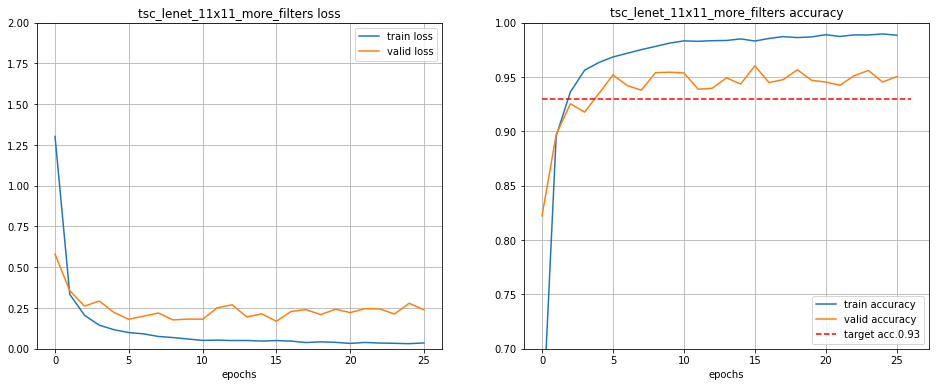

In [42]:
# Training summary/plots generation (collected in history dict)

from functools import reduce

summaries = {
    nn: {
        metric: {
            "train": reduce(lambda x, y: x + y, [x.history[metric] for x in history]),
            "valid": reduce(
                lambda x, y: x + y, [x.history[f"val_{metric}"] for x in history]
            ),
        }
        for metric in ["loss", "accuracy"]
    }
    for nn, history in history.items()
}

for nn, summary in summaries.items():

    plt.figure(figsize=(16, 6))

    for metric, ax in zip(
        summary.keys(), [plt.subplot(1, 2, idx) for idx in range(1, 3)]
    ):
        for set_label, values in summary[metric].items():
            ax.plot(values, label=f"{set_label} {metric}")
            ax.set_xlabel("epochs")
            ax.grid(visible=True)
            ax.set_title(f"{nn} {metric}")
        if metric == "accuracy":
            ax.set_ylim((0.7, 1))
            ax.hlines(
                0.93,
                0,
                len(values),
                color="red",
                linestyle="dashed",
                label="target acc.0.93",
            )
        else:
            ax.set_ylim((0, 2))
        ax.legend()
    # Saving the figure to a file (png)
    plt.savefig(f"./output/{nn}_training_session.png")

### Architecture/model comparison

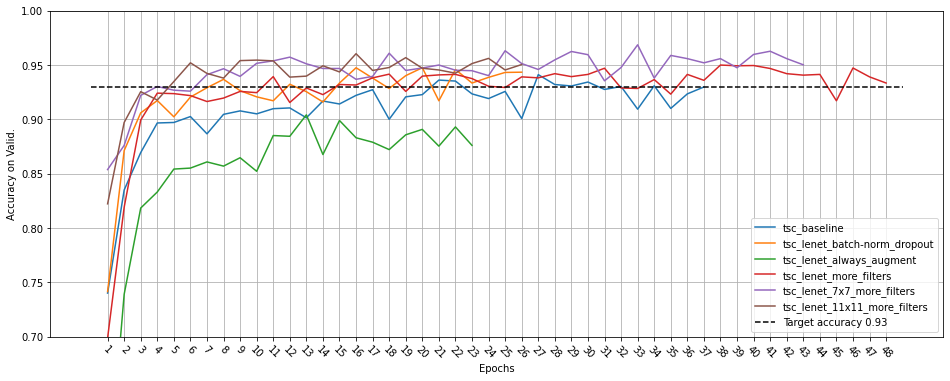

In [43]:
# Accuracy evolution per epoch.  model

plt.figure(figsize=(16, 6))
max_epochs = 1
for model_name, results in summaries.items():
    validation_accuracy = results["accuracy"]["valid"]
    max_epochs = max(1+len(validation_accuracy),  max_epochs)
    plt.xticks(range(1, max_epochs))
    plt.plot(range(1, 1+len(validation_accuracy)), validation_accuracy, label=f"{model_name}")
    
plt.ylim((0.7, 1))
plt.hlines(
                0.93,
                0,
                max_epochs,
                color="black",
                linestyle="dashed",
                label="Target accuracy 0.93",
            )
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Valid.")
plt.xticks(rotation=-45)
plt.grid()
plt.legend()
plt.savefig(f"./output/models_comparison.png")



In [44]:
# Add a visualization of a monotonous increase keeping only 
# the epochs where the accuracy on the validation increases 
# compared to last best reached accuracy  

In [45]:
# Accuracy on train, validation (and test) sets

def accuracy_classes(prediction, gt):
    assert len(prediction) == len(gt)
    return np.sum(prediction == gt) / len(gt)


def accuracy(prediction, gt):
    return accuracy_classes(np.argmax(prediction, axis=1), gt)

# TODO -> add pred. accuracy to the model
for _, network in networks.items(): 
    print(f"\n{network._name}:\n")
    print(f"  Accuracy on the Train set =  {accuracy(network.pred_model(X_train), y_train)}")
    print(f"  Accuracy on the Valid. set = {accuracy(network.pred_model(X_valid), y_valid)}")
    # Test set accuracy
    print(f"  Accuracy on the Test set = {accuracy(network.pred_model(X_test), y_test)}")


tsc_baseline:

  Accuracy on the Train set =  0.9987643323083997
  Accuracy on the Valid. set = 0.9410430839002267
  Accuracy on the Test set = 0.9186064924782265

tsc_lenet_batch-norm_dropout:

  Accuracy on the Train set =  0.9984194948130694
  Accuracy on the Valid. set = 0.9473922902494331
  Accuracy on the Test set = 0.9190023752969121

tsc_lenet_always_augment:

  Accuracy on the Train set =  0.9843098939624702
  Accuracy on the Valid. set = 0.9040816326530612
  Accuracy on the Test set = 0.9007125890736342

tsc_lenet_more_filters:

  Accuracy on the Train set =  0.9981896031495158
  Accuracy on the Valid. set = 0.9498866213151927
  Accuracy on the Test set = 0.9353919239904989

tsc_lenet_7x7_more_filters:

  Accuracy on the Train set =  0.9996551625046697
  Accuracy on the Valid. set = 0.9684807256235828
  Accuracy on the Test set = 0.9506730007917656

tsc_lenet_11x11_more_filters:

  Accuracy on the Train set =  0.9982758125233484
  Accuracy on the Valid. set = 0.9603174603174

## Select the "best" model (based on validation)

In [46]:
# Select the model based on the validation perf.
model_acc_sorted = sorted([ (model, accuracy(network.pred_model(X_valid), y_valid)) for model, network in networks.items()], key= lambda x:x[1], reverse=True)
model_acc_sorted

[('tsc_lenet_7x7_more_filters', 0.9684807256235828),
 ('tsc_lenet_11x11_more_filters', 0.9603174603174603),
 ('tsc_lenet_more_filters', 0.9498866213151927),
 ('tsc_lenet_batch-norm_dropout', 0.9473922902494331),
 ('tsc_baseline', 0.9410430839002267),
 ('tsc_lenet_always_augment', 0.9040816326530612)]

## Inspect validation perf.

In [47]:
model = networks[model_acc_sorted[0][0]]
print(f"Seletected model -> {model.name}")

Seletected model -> tsc_lenet_7x7_more_filters


In [48]:
model.predict(X_valid)[:2]

array([[3.1266387e-12, 1.7944162e-12, 6.3832615e-15, 3.3535917e-17,
        4.1406636e-30, 5.6233115e-11, 9.6193080e-06, 8.1735410e-15,
        4.5145245e-17, 2.8302590e-12, 1.1122917e-14, 8.3372094e-12,
        2.5161576e-11, 5.1588308e-12, 2.0455558e-18, 8.5960295e-18,
        3.4464538e-12, 1.5451685e-14, 5.5930435e-21, 2.6551381e-16,
        5.3702170e-10, 1.8718277e-21, 3.4453472e-17, 6.4263427e-13,
        1.5431615e-23, 1.2913918e-17, 3.1444752e-18, 3.6871766e-18,
        5.3084186e-11, 1.3422635e-14, 1.1965973e-13, 2.5507240e-24,
        4.6941945e-03, 2.1918915e-11, 1.6276166e-16, 3.3020456e-10,
        3.3614824e-09, 3.0250580e-13, 8.4918170e-14, 5.8591283e-08,
        1.0340382e-11, 9.9527669e-01, 1.9464755e-05],
       [5.4506725e-13, 5.2160370e-14, 3.0626993e-16, 6.4912940e-20,
        6.2081035e-30, 1.0368125e-13, 1.1405806e-06, 8.8092922e-17,
        1.7210399e-19, 3.0935148e-13, 3.5282128e-16, 3.9524119e-13,
        2.9382281e-11, 1.0393559e-11, 3.4136472e-19, 1.0962702

In [49]:
def misclassified(model, images, gt):
    """ Returns the mis-classified item indices zipped
        with the predicted and the correct ground truth label 
    
    :param model: model to use for prediction
    :param images: images as a np.array with shape (N, 32, 32,3) 
    :param gt: label as integer of shape (N,)
    """
    predictions = np.argmax(model.predict(images), axis=1) # perform  prediction with the given modl
    misclassified_indices =  np.argwhere(predictions != gt).flatten()
    return np.array(list(zip(misclassified_indices, predictions[misclassified_indices], gt[misclassified_indices])))

In [50]:
valid_misclassified = misclassified(model, X_valid, y_valid)

In [51]:
print(len(valid_misclassified))

139


In [52]:
from traffic_sign_classifier.utils import load_signnames
index2label = load_signnames("./traffic-signs-data/signnames.csv")

In [53]:
from collections import defaultdict

valid_misclassified_by_pred = defaultdict(lambda:[]) # misclassified grouped by predicted class
valid_misclassified_by_gt = defaultdict(lambda:[]) # misclassified grouped by gt clas
for index, prediction, gt in valid_misclassified:
    valid_misclassified_by_pred[prediction].append((index, gt))
    valid_misclassified_by_gt[gt].append((index, prediction))
    # print(f"{index} pred.: {index2label.get(prediction)}, gt: {index2label.get(gt)}")

### Misclassification stats.

In [54]:
# Sorting the missclassification by category (first those with high error rate)
top_mis_nbr = 5 # number of the top misclassified category to summarize
sorted_misclassified = sorted([ (category, misclassifications)
                                          for category, misclassifications in valid_misclassified_by_gt.items()],
                                          key=lambda x: len(x[1]), reverse=True)
for category, misclassification in sorted_misclassified[:top_mis_nbr]:
    print(f"\n(id: {category}) {index2label.get(category)}, {len(misclassification)} incorrectly classified:")
    # Groupping the misclassification by predicted class
    grp = defaultdict(lambda:[])
    for item, predicted in misclassification:
        grp[predicted].append(item)
    for prediction, items in  grp.items():
        print(f"* as {class2label.get(prediction, prediction)} -> {len(items)} time(s)!")
        
    


(id: 21) Double curve, 17 incorrectly classified:
* as Bumpy road -> 1 time(s)!
* as Wild animals crossing -> 10 time(s)!
* as Slippery road -> 3 time(s)!
* as Traffic signals -> 1 time(s)!
* as Road narrows on the right -> 2 time(s)!

(id: 25) Road work, 13 incorrectly classified:
* as Beware of ice/snow -> 3 time(s)!
* as General caution -> 1 time(s)!
* as Go straight or right -> 1 time(s)!
* as Slippery road -> 3 time(s)!
* as Right-of-way at the next intersection -> 3 time(s)!
* as Double curve -> 1 time(s)!
* as Speed limit (50km/h) -> 1 time(s)!

(id: 1) Speed limit (30km/h), 12 incorrectly classified:
* as Speed limit (50km/h) -> 4 time(s)!
* as Speed limit (20km/h) -> 2 time(s)!
* as Speed limit (70km/h) -> 6 time(s)!

(id: 40) Roundabout mandatory, 12 incorrectly classified:
* as Double curve -> 4 time(s)!
* as End of all speed and passing limits -> 8 time(s)!

(id: 20) Dangerous curve to the right, 12 incorrectly classified:
* as Right-of-way at the next intersection -> 1 ti

## Misclassified sample visualization.

Visualizing the most freq. misclassified categories/classes

In [55]:
# most frequently missed categories
most_misclassified_categs, _ = zip(*sorted_misclassified)

In [56]:
# Remark the last contrast (dark images) (histogram equalization could be part of the processing for the )
# Also for the 

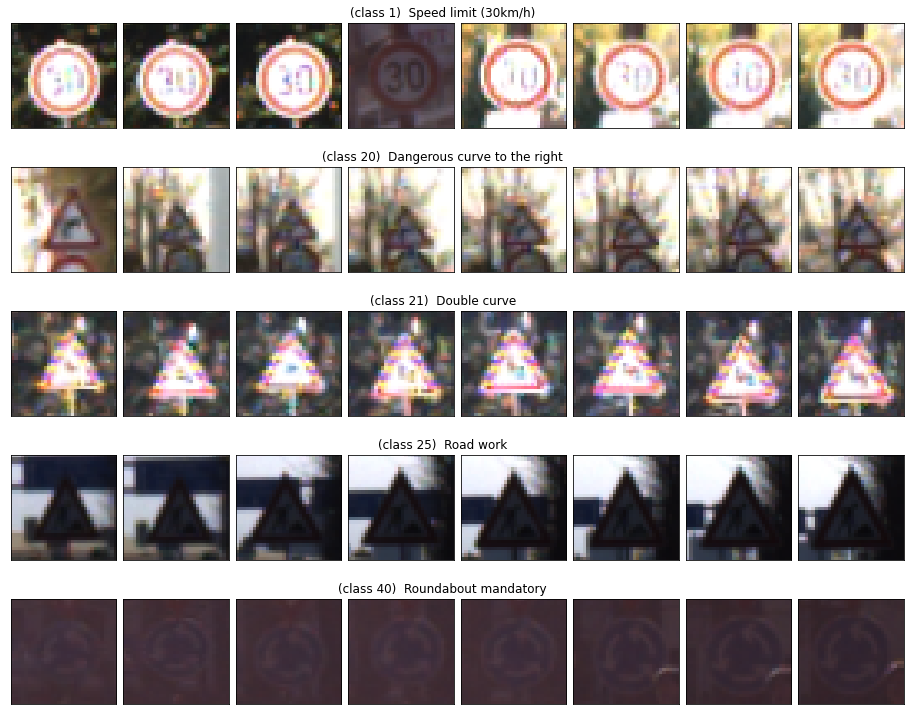

In [57]:
# TODO: fix subfigure bug
grid_visu(X_valid[valid_misclassified[:, 0]], labels=y_valid[valid_misclassified[:, 0]],
                 sample_size=8, categories= most_misclassified_categs[:top_mis_nbr], label_to_name=class2label,
         output_dir_path="./output/misclassified")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [58]:
from typing import List
from glob import glob

import cv2

test_paths = [image_path for image_path in glob("./examples/test_sample/*.png")]

# For convinience and batch/faster prediction that we resize the new image to (32x32)
# 32x32 resizing is part of the preprocessing for prediction though!

def extract_test_cate(image_path) -> int:
    """ Extract test category/class from image path. 
        convension for naming the files [class]_[id].extension
    """
    return int(os.path.split(os.path.basename(image_path))[-1].split("_")[0])

def load_data(paths: List[str], label_extractor=extract_test_cate):
    """ A helper loading  the images from a list of paths 
    and extract the label from their path using the label extractor
    """ 
    for path in sorted(paths):
        yield  path, cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (32,32)) , label_extractor(path)

In [59]:
# sample_test_image = cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB)
# sample_test_image.reshape( [1] , sample_test_image.shape()
# As the resizing and scaling 
model.predict(np.expand_dims(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB), axis=0))

array([[3.6114168e-05, 4.4869408e-02, 2.5412840e-01, 4.2204288e-08,
        2.6571700e-08, 1.6092779e-01, 3.0956601e-06, 4.3958739e-06,
        1.5756211e-07, 7.6279698e-11, 9.2657837e-09, 2.4777753e-06,
        3.3544554e-13, 7.1566333e-08, 1.7224538e-08, 1.8706423e-10,
        8.4040813e-08, 2.8727521e-15, 1.8370921e-08, 4.8901505e-10,
        8.7877322e-07, 8.7792917e-10, 1.7474782e-11, 4.0482282e-06,
        2.3530606e-06, 4.2583860e-11, 2.0500037e-11, 4.3059005e-09,
        1.2946302e-07, 2.3018002e-12, 1.5581158e-07, 8.8936211e-08,
        6.1179395e-11, 1.0355674e-08, 6.3881527e-07, 6.5916126e-09,
        5.2995063e-07, 4.6415889e-07, 6.8802848e-07, 1.4673329e-05,
        5.4000276e-01, 4.3763080e-07, 1.7790072e-10]], dtype=float32)

In [60]:
model.predict(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB))

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[3.6114227e-05, 4.4869520e-02, 2.5412843e-01, 4.2204274e-08,
        2.6571790e-08, 1.6092788e-01, 3.0956651e-06, 4.3958762e-06,
        1.5756250e-07, 7.6279809e-11, 9.2657624e-09, 2.4777769e-06,
        3.3544540e-13, 7.1566568e-08, 1.7224531e-08, 1.8706449e-10,
        8.4040707e-08, 2.8727510e-15, 1.8370914e-08, 4.8901577e-10,
        8.7877368e-07, 8.7792884e-10, 1.7474806e-11, 4.0482346e-06,
        2.3530597e-06, 4.2583763e-11, 2.0500069e-11, 4.3059152e-09,
        1.2946309e-07, 2.3017994e-12, 1.5581166e-07, 8.8936432e-08,
        6.1179492e-11, 1.0355650e-08, 6.3881441e-07, 6.5915975e-09,
        5.2995040e-07, 4.6415957e-07, 6.8802888e-07, 1.4673324e-05,
        5.4000252e-01, 4.3763146e-07, 1.7790065e-10]], dtype=float32)>

In [61]:
test_paths, test_images , test_labels =zip(* load_data(test_paths))
print(len(test_paths))

14


In [62]:
# Generate md image-set

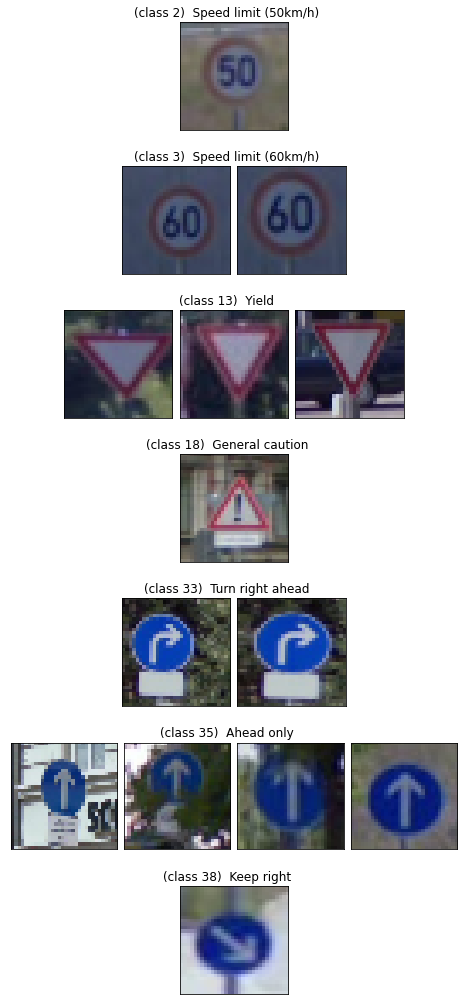

In [63]:
# Todo center the visualization
grid_visu(test_images, test_labels, sample_size=4, label_to_name=class2label, categories_per_fig=8,  output_dir_path="./output/ext_new")

### Predict the Sign Type for Each Image

In [64]:
# To move to LeNet (class) as a method
from typing import Iterable
from traffic_sign_classifier.nn.utils import softmax

def predict_paths(paths: Iterable[str]=test_paths, top_k=5):
    """ Predict a list of image paths """
    for path, image, label  in load_data(paths):
        image = image.reshape([1] + list(image.shape))
        prediction = (model.predict(image)).flatten()
        pred_categ = np.argmax(prediction)
        print(f" {path}: gt: {label} -> predicted category ({pred_categ}:{class2label[pred_categ]}) ")
        if top_k is not None:
            for softmax_output, category in sorted(zip(softmax(prediction), range(len(prediction))), reverse=True)[:top_k]:
                print(f"        {category} {softmax_output} {class2label[category]} -> {category}")
        yield path, label, pred_categ
        

In [65]:
ext_paths, ext_gt, ext_pred = zip(*predict_paths(test_paths))

 ./examples/test_sample/13_1.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/13_2.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/13_3.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
       

In [66]:
# Predicition to md
# TODO: mv as utils helper function 
from IPython.display import Markdown, display
from typing import Dict

def render_pred_cell(pred, actual, class2label:Dict):
    """ Render pred cell with correct vs not background"""
    if pred == actual :
        return  f'<p style="background:green; opacity=0.3"> {pred},  {class2label.get(pred, pred)} </p>'
    return  f'<p style="background:red; opacity=0.3"> {pred}, {class2label.get(pred, pred)} </p>'

header = "\n".join(["| Image | Ground truth | Prediction | ","|:-----:|:------------:|:----------:|"])
rows  = []
for path_, gt_, pred_ in sorted(zip(ext_paths, ext_gt, ext_pred)):
    rows.append(f"| {path_} | {gt_}, {class2label[gt_]}|  {render_pred_cell(pred_, gt_, class2label)}|")

table = "\n".join([header]+rows)                
display(Markdown(table))
print(table)

| Image | Ground truth | Prediction | 
|:-----:|:------------:|:----------:|
| ./examples/test_sample/13_1.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_2.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_3.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/18_1.png | 18, General caution|  <p style="background:red; opacity=0.3"> 19, Dangerous curve to the left </p>|
| ./examples/test_sample/2_1.png | 2, Speed limit (50km/h)|  <p style="background:red; opacity=0.3"> 40, Roundabout mandatory </p>|
| ./examples/test_sample/33_1.png | 33, Turn right ahead|  <p style="background:red; opacity=0.3"> 39, Keep left </p>|
| ./examples/test_sample/33_2.png | 33, Turn right ahead|  <p style="background:green; opacity=0.3"> 33,  Turn right ahead </p>|
| ./examples/test_sample/35_1.png | 35, Ahead only|  <p style="background:red; opacity=0.3"> 40, Roundabout mandatory </p>|
| ./examples/test_sample/35_2.png | 35, Ahead only|  <p style="background:red; opacity=0.3"> 39, Keep left </p>|
| ./examples/test_sample/35_3.png | 35, Ahead only|  <p style="background:green; opacity=0.3"> 35,  Ahead only </p>|
| ./examples/test_sample/35_4.png | 35, Ahead only|  <p style="background:green; opacity=0.3"> 35,  Ahead only </p>|
| ./examples/test_sample/38_1.png | 38, Keep right|  <p style="background:green; opacity=0.3"> 38,  Keep right </p>|
| ./examples/test_sample/3_1.png | 3, Speed limit (60km/h)|  <p style="background:green; opacity=0.3"> 3,  Speed limit (60km/h) </p>|
| ./examples/test_sample/3_2.png | 3, Speed limit (60km/h)|  <p style="background:red; opacity=0.3"> 40, Roundabout mandatory </p>|

| Image | Ground truth | Prediction | 
|:-----:|:------------:|:----------:|
| ./examples/test_sample/13_1.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_2.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_3.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/18_1.png | 18, General caution|  <p style="background:red; opacity=0.3"> 19, Dangerous curve to the left </p>|
| ./examples/test_sample/2_1.png | 2, Speed limit (50km/h)|  <p style="background:red; opacity=0.3"> 40, Roundabout mandatory </p>|
| ./examples/test_sample/33_1.png | 33, Turn right ahead|  <p style="background:red; opacity=0.3"> 39, Keep left </p>|
| ./examples/test_sample/33_2.png | 33, Turn right ahead|  <p style="background:green; opacity=0.3"> 33,  Turn right ahead </p>|
| ./examples/test_sample/35_1.png | 35, Ahead only|  <p style="background:red; opacity

In [67]:
from traffic_sign_classifier.utils import accuracy_classes
correct_ext = np.sum(np.array(ext_pred)==np.array(ext_gt)) 
acc_ext = accuracy_classes(np.array(ext_pred), np.array(ext_gt))

print(f"The model was able to correctly guess {correct_ext} of the {len(ext_pred)} traffic signs, which gives an accuracy of {acc_ext:.2f}")

The model was able to correctly guess 8 of the 14 traffic signs, which gives an accuracy of 0.57


### Analyze Performance

In [68]:
print (f" accuracy on the new sample -> {100*accuracy_classes(np.array(ext_gt), np.array(ext_pred)):.2f}%")

 accuracy on the new sample -> 57.14%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [69]:
# predict the images (in batch)
prediction = model.predict(np.array(test_images))
top_k = tf.nn.top_k(softmax(prediction), k=5)
ext_probs = top_k.values
ext_classes = top_k.indices

In [70]:
zip( test_images, *zip(*(map(np.array, zip(ext_probs, ext_classes)))))

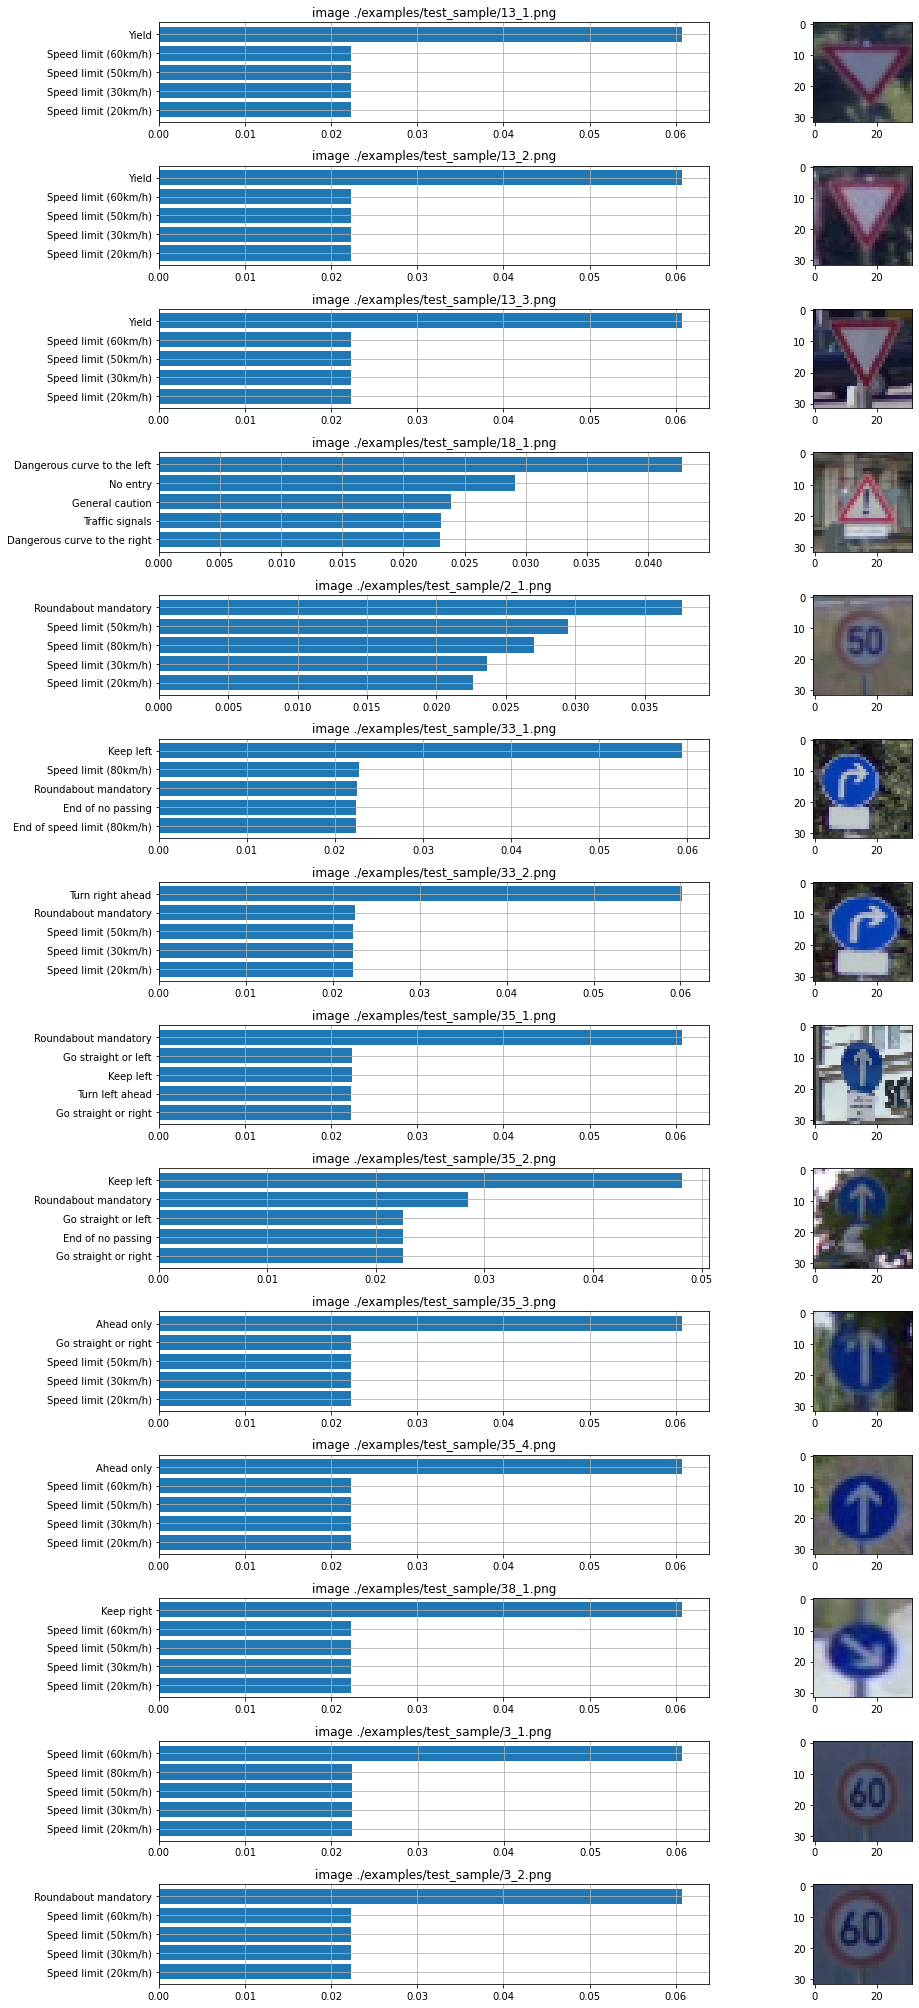

In [71]:
index = 1
plt.figure(figsize=(16, len(test_images)*2))
# TODO sort by classes (file name)
for image_file, test_image, probs, categs in zip(test_paths, test_images, *zip(*map(np.array, zip(ext_probs, ext_classes)))):
    ax = plt.subplot(len(test_images), 2, index)
    sorted_categs, sorted_probs = zip(*sorted(zip(categs, probs), key=lambda x: x [1]))
    categ_labels = [class2label.get(item, item) for item in sorted_categs]
    ax.barh(range(len(categ_labels))
            , sorted_probs, tick_label=categ_labels)
    ax.set_title(f"image {image_file}")
    ax.grid()
    index += 1
    ax_image = plt.subplot(len(test_images), 2, index)
    ax_image.imshow(test_image)
    index += 1
plt.tight_layout()
# TODO save the output
plt.savefig(f"./output/top_5_softmax_probs.png")

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



In [72]:
for layer in model.pred_model.layers:
    print(layer.name)

input_5
resizing
rescaling
conv2d_8
batch_normalization_6
max_pooling2d_8
conv2d_9
batch_normalization_7
max_pooling2d_9
flatten_4
dense_12
dense_13
dense_14


In [73]:
from mpl_toolkits.axes_grid1 import ImageGrid
from traffic_sign_classifier.visualization import show_image

def visualize_feature_map_output(images, model, layer_name, images_per_figure=5, output_dir_path: Optional[str] = None,
    output_ext: str = "jpg"):
    """ Visualize the feature map output
    
    :param images: images np.array to be fed to the network (for which the feature map will be produced)
    :param model: prediction model
    :param layer_name: layer_name as the selector for the layer output/feature map to be visualized
    :param images_per_figure: the number of image to group by figure
    
    """

    activation_model = tf.keras.Model(
        model.pred_model.input, model.pred_model.get_layer(layer_name).output
    )
    # TODO: replace images, model, layer_name with the activation model output (limit the helper to only visualization)
    activation_output = activation_model.predict(np.array(images)).transpose(0, 3, 1, 2)
    
    # TODO group per category instead of the images per figure

    feature_map_nbr = activation_output.shape[1]
    offset = 0
    for idx, grp in enumerate(
        [
            activation_output[i : i + images_per_figure]
            for i in range(0, activation_output.shape[0], images_per_figure)
        ]
    ):
        subfigs = plt.figure(
            # constrained_layout=True,
            figsize=(2 * grp.shape[1], 2 * len(grp)),
            tight_layout=False,
        ).subfigures(grp.shape[0], 1, wspace=0.01)

        if not isinstance(subfigs, Iterable):
            subfigs = [subfigs]
            
        
        for image_idx, ft_map, fig in zip(range(grp.shape[0]), grp, subfigs):
            grid = ImageGrid(
                fig,
                111,
                nrows_ncols=(1, feature_map_nbr),
                axes_pad=0.4,
            )
            for ax, ft_map_idx in zip(grid, range(ft_map.shape[0])):
                title = f"FeatureMap {ft_map_idx}"
                # print("ft_map",  ft_map[idx].shape)
                if idx is not None:
                    show_image(ax, ft_map[ft_map_idx], title, cmap="plasma")

            fig.suptitle(
                f"layer: {layer_name}, image: {offset + image_idx} ",
                fontsize="large",
            )
        # TODO add original image to the visualization and 
        offset += len(grp)

In [74]:
conv_layer_names =  [layer.name for layer in  model.pred_model.layers if  layer.name.startswith("conv")]

In [75]:
conv_layer_names

['conv2d_8', 'conv2d_9']

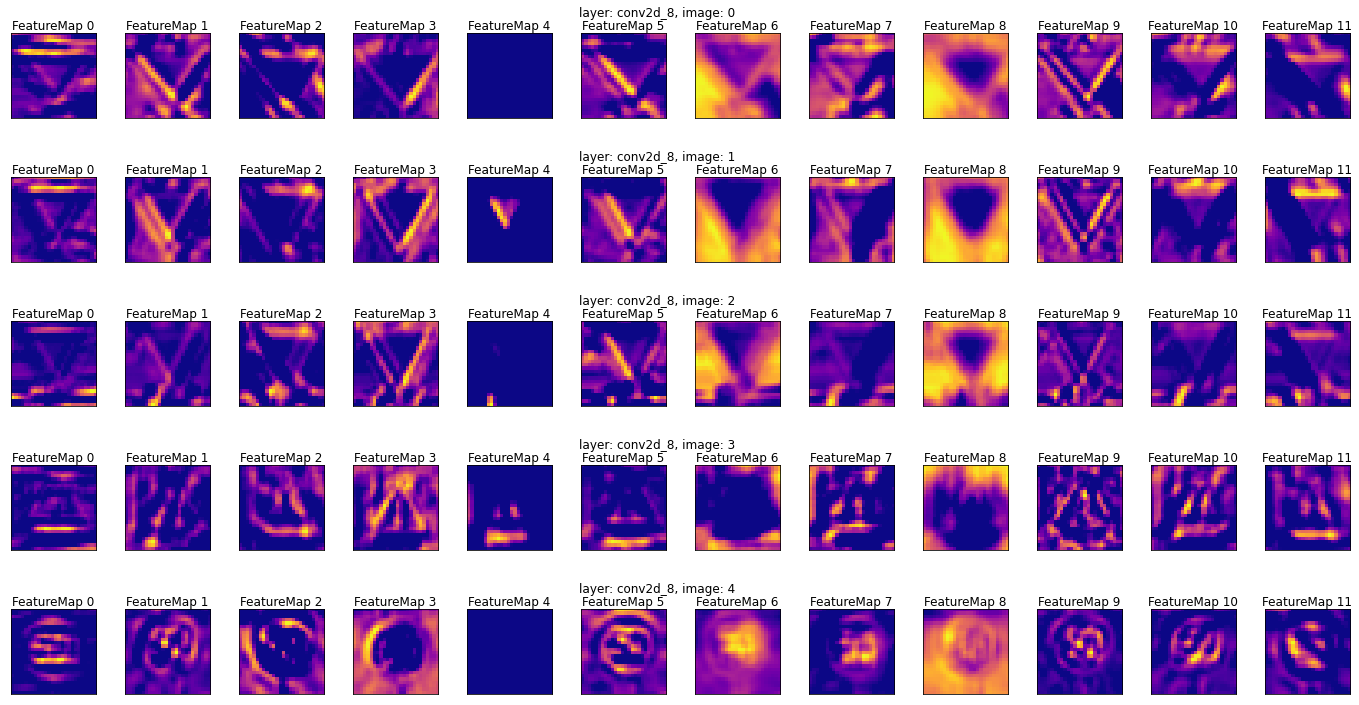

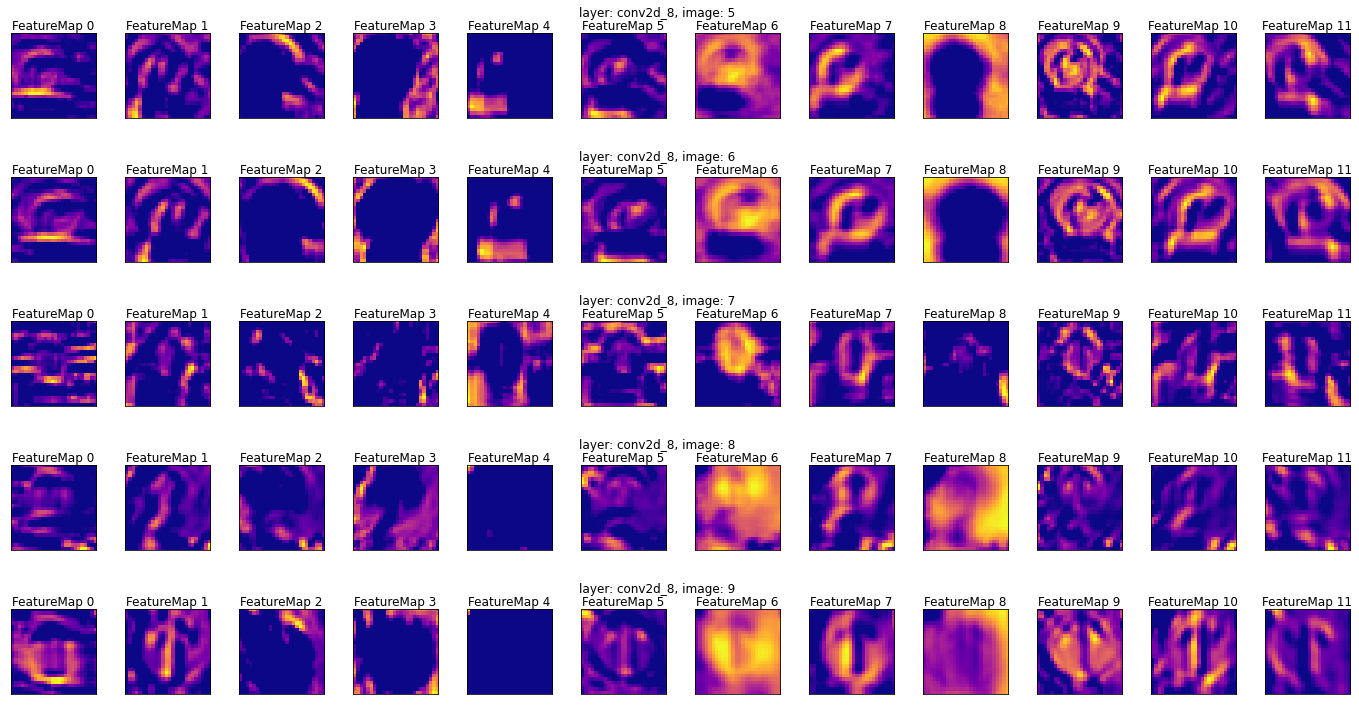

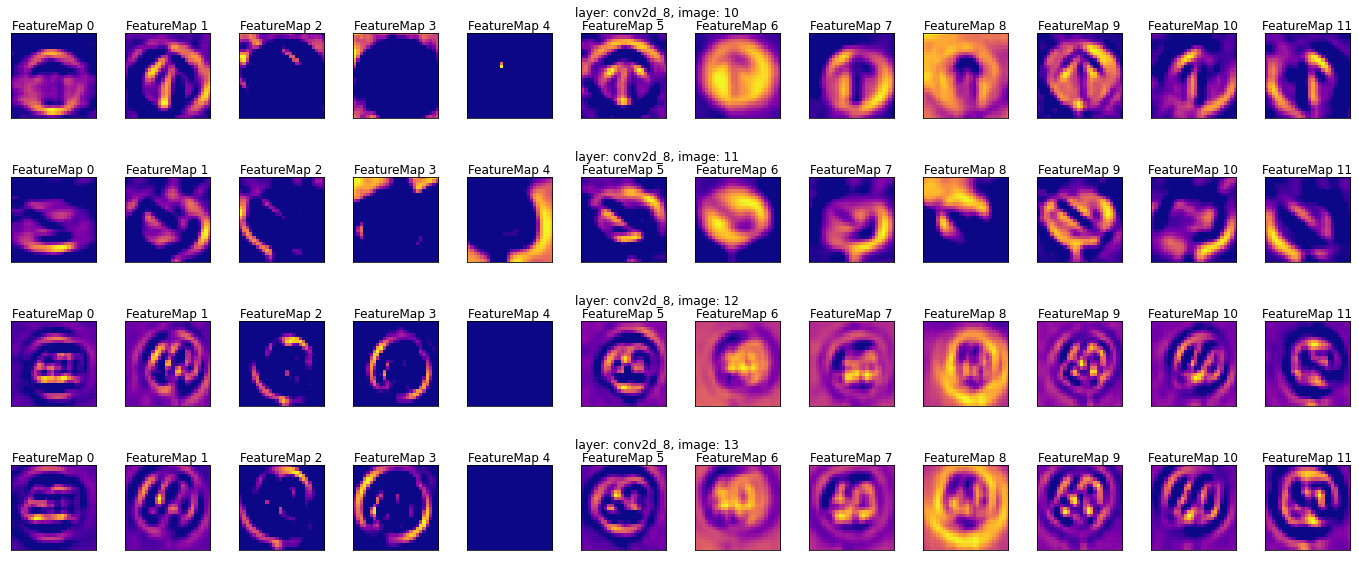

In [76]:
for layer_name in  conv_layer_names[:1]:
    visualize_feature_map_output(test_images, model, layer_name)